In [1]:
import numpy as np
import torch

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = ""
model_name = "flow_ss_vcr_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "CIFAR10"
ood = "0:1:2:3:4"


In [4]:
# initialize data attributes and loaders
from config import load_config

config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

Files already downloaded and verified


  0%|                                                                                                                            | 0/50000 [00:00<?, ?it/s]

  9%|█████████▌                                                                                                    | 4337/50000 [00:00<00:01, 43365.08it/s]

 17%|███████████████████▏                                                                                          | 8749/50000 [00:00<00:00, 43802.46it/s]

 26%|████████████████████████████▊                                                                                | 13233/50000 [00:00<00:00, 44271.71it/s]

 35%|██████████████████████████████████████▋                                                                      | 17725/50000 [00:00<00:00, 44525.33it/s]

 44%|████████████████████████████████████████████████▍                                                            | 22217/50000 [00:00<00:00, 44664.35it/s]

 53%|██████████████████████████████████████████████████████████▏                                                  | 26706/50000 [00:00<00:00, 44737.81it/s]

 62%|███████████████████████████████████████████████████████████████████▉                                         | 31182/50000 [00:00<00:00, 44743.75it/s]

 71%|█████████████████████████████████████████████████████████████████████████████▋                               | 35657/50000 [00:00<00:00, 44677.57it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████▌                     | 40145/50000 [00:00<00:00, 44739.53it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████▎           | 44619/50000 [00:01<00:00, 44666.36it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████  | 49111/50000 [00:01<00:00, 44742.05it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:01<00:00, 44578.87it/s]

Files already downloaded and verified


  0%|                                                                                                                            | 0/10000 [00:00<?, ?it/s]

 42%|██████████████████████████████████████████████▎                                                               | 4211/10000 [00:00<00:00, 42101.41it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████▏              | 8652/10000 [00:00<00:00, 43455.96it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 42855.56it/s]

In [5]:
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

In [6]:
# model ids
import pandas as pd
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

0:1:2:3:4 hzmh6lr2


In [7]:
model = config.get_model()

In [8]:
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger

artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb:   1 of 1 files downloaded.  


In [9]:
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [10]:
from tqdm import tqdm

trn_inp = []
trn_e_u = []
trn_e_v = []
trn_rcn = []
trn_tgt = []

val_inp = []
val_e_u = []
val_e_v = []
val_rcn = []
val_tgt = []

ind_inp = []
ind_e_u = []
ind_e_v = []
ind_rcn = []
ind_tgt = []

if ood_str:
    ood_inp = []
    ood_e_u = []
    ood_e_v = []
    ood_rcn = []
    ood_tgt = []

rnd_inp = []
rnd_e_u = []
rnd_e_v = []
rnd_rcn = []

# train set (ind)
for batch_idx, batch in enumerate(tqdm(train_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
    trn_inp.extend(x.detach().cpu().numpy())
    trn_e_u.extend(e_u.detach().cpu().numpy())
    trn_e_v.extend(e_v.detach().cpu().numpy())
    trn_rcn.extend(rcn.detach().cpu().numpy())
    trn_tgt.extend(y.detach().cpu().numpy())
print("train - OK")

# val set (ind)
for batch_idx, batch in enumerate(tqdm(val_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
    val_inp.extend(x.detach().cpu().numpy())
    val_e_u.extend(e_u.detach().cpu().numpy())
    val_e_v.extend(e_v.detach().cpu().numpy())
    val_rcn.extend(rcn.detach().cpu().numpy())
    val_tgt.extend(y.detach().cpu().numpy())
print("val - OK")

# test set (ind)
for batch_idx, batch in enumerate(tqdm(test_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
    ind_inp.extend(x.detach().cpu().numpy())
    ind_e_u.extend(e_u.detach().cpu().numpy())
    ind_e_v.extend(e_v.detach().cpu().numpy())
    ind_rcn.extend(rcn.detach().cpu().numpy())
    ind_tgt.extend(y.detach().cpu().numpy())
print("test InD - OK")

# predict set (ood)
if ood_str:
    for batch_idx, batch in enumerate(tqdm(predict_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        ood_inp.extend(x.detach().cpu().numpy())
        ood_e_u.extend(e_u.detach().cpu().numpy())
        ood_e_v.extend(e_v.detach().cpu().numpy())
        ood_rcn.extend(rcn.detach().cpu().numpy())
        ood_tgt.extend(y.detach().cpu().numpy())
    print("test OoD - OK")

# random set
rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
for batch_idx, batch in enumerate(tqdm(rnd_set)):
    x = batch
    x = x.float().cuda()
    (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
    rnd_inp.extend(x.detach().cpu().numpy())
    rnd_e_u.extend(e_u.detach().cpu().numpy())
    rnd_e_v.extend(e_v.detach().cpu().numpy())
    rnd_rcn.extend(rcn.detach().cpu().numpy())
print("test RnD - OK")

  0%|                                                                                                                              | 0/313 [00:00<?, ?it/s]

  0%|▍                                                                                                                     | 1/313 [00:00<04:12,  1.24it/s]

  1%|█▌                                                                                                                    | 4/313 [00:00<00:58,  5.29it/s]

  2%|██▋                                                                                                                   | 7/313 [00:01<00:33,  9.05it/s]

  3%|███▋                                                                                                                 | 10/313 [00:01<00:24, 12.38it/s]

  4%|████▊                                                                                                                | 13/313 [00:01<00:19, 15.17it/s]

  5%|█████▉                                                                                                               | 16/313 [00:01<00:17, 17.41it/s]

  6%|███████                                                                                                              | 19/313 [00:01<00:15, 19.13it/s]

  7%|████████▏                                                                                                            | 22/313 [00:01<00:14, 20.45it/s]

  8%|█████████▎                                                                                                           | 25/313 [00:01<00:13, 21.41it/s]

  9%|██████████▍                                                                                                          | 28/313 [00:01<00:12, 22.11it/s]

 10%|███████████▌                                                                                                         | 31/313 [00:02<00:12, 22.61it/s]

 11%|████████████▋                                                                                                        | 34/313 [00:02<00:12, 22.98it/s]

 12%|█████████████▊                                                                                                       | 37/313 [00:02<00:11, 23.22it/s]

 13%|██████████████▉                                                                                                      | 40/313 [00:02<00:11, 23.39it/s]

 14%|████████████████                                                                                                     | 43/313 [00:02<00:11, 23.53it/s]

 15%|█████████████████▏                                                                                                   | 46/313 [00:02<00:11, 23.63it/s]

 16%|██████████████████▎                                                                                                  | 49/313 [00:02<00:11, 23.69it/s]

 17%|███████████████████▍                                                                                                 | 52/313 [00:02<00:10, 23.74it/s]

 18%|████████████████████▌                                                                                                | 55/313 [00:03<00:10, 23.78it/s]

 19%|█████████████████████▋                                                                                               | 58/313 [00:03<00:10, 23.78it/s]

 19%|██████████████████████▊                                                                                              | 61/313 [00:03<00:10, 23.80it/s]

 20%|███████████████████████▉                                                                                             | 64/313 [00:03<00:10, 23.81it/s]

 21%|█████████████████████████                                                                                            | 67/313 [00:03<00:10, 23.69it/s]

 22%|██████████████████████████▏                                                                                          | 70/313 [00:03<00:10, 23.72it/s]

 23%|███████████████████████████▎                                                                                         | 73/313 [00:03<00:10, 23.74it/s]

 24%|████████████████████████████▍                                                                                        | 76/313 [00:03<00:09, 23.75it/s]

 25%|█████████████████████████████▌                                                                                       | 79/313 [00:04<00:09, 23.77it/s]

 26%|██████████████████████████████▋                                                                                      | 82/313 [00:04<00:09, 23.77it/s]

 27%|███████████████████████████████▊                                                                                     | 85/313 [00:04<00:09, 23.79it/s]

 28%|████████████████████████████████▉                                                                                    | 88/313 [00:04<00:09, 23.79it/s]

 29%|██████████████████████████████████                                                                                   | 91/313 [00:04<00:09, 23.80it/s]

 30%|███████████████████████████████████▏                                                                                 | 94/313 [00:04<00:09, 23.80it/s]

 31%|████████████████████████████████████▎                                                                                | 97/313 [00:04<00:09, 23.70it/s]

 32%|█████████████████████████████████████                                                                               | 100/313 [00:04<00:08, 23.73it/s]

 33%|██████████████████████████████████████▏                                                                             | 103/313 [00:05<00:08, 23.74it/s]

 34%|███████████████████████████████████████▎                                                                            | 106/313 [00:05<00:08, 23.75it/s]

 35%|████████████████████████████████████████▍                                                                           | 109/313 [00:05<00:08, 23.76it/s]

 36%|█████████████████████████████████████████▌                                                                          | 112/313 [00:05<00:08, 23.76it/s]

 37%|██████████████████████████████████████████▌                                                                         | 115/313 [00:05<00:08, 23.75it/s]

 38%|███████████████████████████████████████████▋                                                                        | 118/313 [00:05<00:08, 23.76it/s]

 39%|████████████████████████████████████████████▊                                                                       | 121/313 [00:05<00:08, 23.75it/s]

 40%|█████████████████████████████████████████████▉                                                                      | 124/313 [00:05<00:07, 23.75it/s]

 41%|███████████████████████████████████████████████                                                                     | 127/313 [00:06<00:07, 23.76it/s]

 42%|████████████████████████████████████████████████▏                                                                   | 130/313 [00:06<00:07, 23.77it/s]

 42%|█████████████████████████████████████████████████▎                                                                  | 133/313 [00:06<00:07, 23.78it/s]

 43%|██████████████████████████████████████████████████▍                                                                 | 136/313 [00:06<00:07, 23.77it/s]

 44%|███████████████████████████████████████████████████▌                                                                | 139/313 [00:06<00:07, 23.77it/s]

 45%|████████████████████████████████████████████████████▋                                                               | 142/313 [00:06<00:07, 23.75it/s]

 46%|█████████████████████████████████████████████████████▋                                                              | 145/313 [00:06<00:07, 23.75it/s]

 47%|██████████████████████████████████████████████████████▊                                                             | 148/313 [00:06<00:06, 23.75it/s]

 48%|███████████████████████████████████████████████████████▉                                                            | 151/313 [00:07<00:06, 23.74it/s]

 49%|█████████████████████████████████████████████████████████                                                           | 154/313 [00:07<00:06, 23.72it/s]

 50%|██████████████████████████████████████████████████████████▏                                                         | 157/313 [00:07<00:06, 23.67it/s]

 51%|███████████████████████████████████████████████████████████▎                                                        | 160/313 [00:07<00:06, 23.65it/s]

 52%|████████████████████████████████████████████████████████████▍                                                       | 163/313 [00:07<00:06, 23.64it/s]

 53%|█████████████████████████████████████████████████████████████▌                                                      | 166/313 [00:07<00:06, 23.62it/s]

 54%|██████████████████████████████████████████████████████████████▋                                                     | 169/313 [00:07<00:06, 23.61it/s]

 55%|███████████████████████████████████████████████████████████████▋                                                    | 172/313 [00:08<00:05, 23.60it/s]

 56%|████████████████████████████████████████████████████████████████▊                                                   | 175/313 [00:08<00:05, 23.58it/s]

 57%|█████████████████████████████████████████████████████████████████▉                                                  | 178/313 [00:08<00:05, 23.58it/s]

 58%|███████████████████████████████████████████████████████████████████                                                 | 181/313 [00:08<00:05, 23.42it/s]

 59%|████████████████████████████████████████████████████████████████████▏                                               | 184/313 [00:08<00:05, 23.47it/s]

 60%|█████████████████████████████████████████████████████████████████████▎                                              | 187/313 [00:08<00:05, 23.50it/s]

 61%|██████████████████████████████████████████████████████████████████████▍                                             | 190/313 [00:08<00:05, 23.53it/s]

 62%|███████████████████████████████████████████████████████████████████████▌                                            | 193/313 [00:08<00:05, 23.55it/s]

 63%|████████████████████████████████████████████████████████████████████████▋                                           | 196/313 [00:09<00:04, 23.56it/s]

 64%|█████████████████████████████████████████████████████████████████████████▊                                          | 199/313 [00:09<00:04, 23.56it/s]

 65%|██████████████████████████████████████████████████████████████████████████▊                                         | 202/313 [00:09<00:04, 23.59it/s]

 65%|███████████████████████████████████████████████████████████████████████████▉                                        | 205/313 [00:09<00:04, 23.59it/s]

 66%|█████████████████████████████████████████████████████████████████████████████                                       | 208/313 [00:09<00:04, 23.59it/s]

 67%|██████████████████████████████████████████████████████████████████████████████▏                                     | 211/313 [00:09<00:04, 23.44it/s]

 68%|███████████████████████████████████████████████████████████████████████████████▎                                    | 214/313 [00:09<00:04, 23.48it/s]

 69%|████████████████████████████████████████████████████████████████████████████████▍                                   | 217/313 [00:09<00:04, 23.51it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████▌                                  | 220/313 [00:10<00:03, 23.54it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████▋                                 | 223/313 [00:10<00:03, 23.54it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████▊                                | 226/313 [00:10<00:03, 23.55it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████▊                               | 229/313 [00:10<00:03, 23.57it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████▉                              | 232/313 [00:10<00:03, 23.58it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████                             | 235/313 [00:10<00:03, 23.57it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████▏                           | 238/313 [00:10<00:03, 23.57it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████▎                          | 241/313 [00:10<00:03, 23.57it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████▍                         | 244/313 [00:11<00:02, 23.56it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████▌                        | 247/313 [00:11<00:02, 23.51it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████▋                       | 250/313 [00:11<00:02, 23.48it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████▊                      | 253/313 [00:11<00:02, 23.51it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████▉                     | 256/313 [00:11<00:02, 23.52it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████▉                    | 259/313 [00:11<00:02, 23.54it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████                   | 262/313 [00:11<00:02, 23.55it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 265/313 [00:11<00:02, 23.56it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                | 268/313 [00:12<00:01, 23.60it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 271/313 [00:12<00:01, 23.63it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 274/313 [00:12<00:01, 23.65it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 277/313 [00:12<00:01, 23.66it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 280/313 [00:12<00:01, 23.67it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 283/313 [00:12<00:01, 23.55it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 286/313 [00:12<00:01, 23.57it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████         | 289/313 [00:12<00:01, 23.60it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 292/313 [00:13<00:00, 23.63it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 295/313 [00:13<00:00, 23.65it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 298/313 [00:13<00:00, 23.66it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 301/313 [00:13<00:00, 23.68it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 304/313 [00:13<00:00, 23.68it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 307/313 [00:13<00:00, 23.65it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 310/313 [00:13<00:00, 23.67it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:14<00:00, 22.65it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:14<00:00, 22.30it/s]

train - OK


  0%|                                                                                                                               | 0/79 [00:00<?, ?it/s]

  1%|█▌                                                                                                                     | 1/79 [00:00<00:10,  7.43it/s]

  5%|██████                                                                                                                 | 4/79 [00:00<00:04, 16.52it/s]

  9%|██████████▌                                                                                                            | 7/79 [00:00<00:03, 19.63it/s]

 13%|██████████████▉                                                                                                       | 10/79 [00:00<00:03, 21.12it/s]

 16%|███████████████████▍                                                                                                  | 13/79 [00:00<00:03, 21.94it/s]

 20%|███████████████████████▉                                                                                              | 16/79 [00:00<00:02, 22.45it/s]

 24%|████████████████████████████▍                                                                                         | 19/79 [00:00<00:02, 22.72it/s]

 28%|████████████████████████████████▊                                                                                     | 22/79 [00:01<00:02, 22.94it/s]

 32%|█████████████████████████████████████▎                                                                                | 25/79 [00:01<00:02, 23.10it/s]

 35%|█████████████████████████████████████████▊                                                                            | 28/79 [00:01<00:02, 23.19it/s]

 39%|██████████████████████████████████████████████▎                                                                       | 31/79 [00:01<00:02, 23.23it/s]

 43%|██████████████████████████████████████████████████▊                                                                   | 34/79 [00:01<00:01, 23.28it/s]

 47%|███████████████████████████████████████████████████████▎                                                              | 37/79 [00:01<00:01, 23.27it/s]

 51%|███████████████████████████████████████████████████████████▋                                                          | 40/79 [00:01<00:01, 23.31it/s]

 54%|████████████████████████████████████████████████████████████████▏                                                     | 43/79 [00:01<00:01, 23.34it/s]

 58%|████████████████████████████████████████████████████████████████████▋                                                 | 46/79 [00:02<00:01, 23.40it/s]

 62%|█████████████████████████████████████████████████████████████████████████▏                                            | 49/79 [00:02<00:01, 23.46it/s]

 66%|█████████████████████████████████████████████████████████████████████████████▋                                        | 52/79 [00:02<00:01, 23.50it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████▏                                   | 55/79 [00:02<00:01, 23.52it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████▋                               | 58/79 [00:02<00:00, 23.53it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████                           | 61/79 [00:02<00:00, 23.55it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████▌                      | 64/79 [00:02<00:00, 23.56it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████                  | 67/79 [00:02<00:00, 23.56it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 70/79 [00:03<00:00, 23.55it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 73/79 [00:03<00:00, 23.55it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 76/79 [00:03<00:00, 23.57it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:03<00:00, 22.41it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:03<00:00, 22.48it/s]

val - OK


  0%|                                                                                                                               | 0/79 [00:00<?, ?it/s]

  1%|█▌                                                                                                                     | 1/79 [00:00<00:10,  7.24it/s]

  5%|██████                                                                                                                 | 4/79 [00:00<00:04, 16.35it/s]

  9%|██████████▌                                                                                                            | 7/79 [00:00<00:03, 19.55it/s]

 13%|██████████████▉                                                                                                       | 10/79 [00:00<00:03, 21.09it/s]

 16%|███████████████████▍                                                                                                  | 13/79 [00:00<00:03, 21.98it/s]

 20%|███████████████████████▉                                                                                              | 16/79 [00:00<00:02, 22.47it/s]

 24%|████████████████████████████▍                                                                                         | 19/79 [00:00<00:02, 22.79it/s]

 28%|████████████████████████████████▊                                                                                     | 22/79 [00:01<00:02, 23.02it/s]

 32%|█████████████████████████████████████▎                                                                                | 25/79 [00:01<00:02, 23.11it/s]

 35%|█████████████████████████████████████████▊                                                                            | 28/79 [00:01<00:02, 23.24it/s]

 39%|██████████████████████████████████████████████▎                                                                       | 31/79 [00:01<00:02, 23.33it/s]

 43%|██████████████████████████████████████████████████▊                                                                   | 34/79 [00:01<00:01, 23.38it/s]

 47%|███████████████████████████████████████████████████████▎                                                              | 37/79 [00:01<00:01, 23.41it/s]

 51%|███████████████████████████████████████████████████████████▋                                                          | 40/79 [00:01<00:01, 23.43it/s]

 54%|████████████████████████████████████████████████████████████████▏                                                     | 43/79 [00:01<00:01, 23.47it/s]

 58%|████████████████████████████████████████████████████████████████████▋                                                 | 46/79 [00:02<00:01, 23.48it/s]

 62%|█████████████████████████████████████████████████████████████████████████▏                                            | 49/79 [00:02<00:01, 23.49it/s]

 66%|█████████████████████████████████████████████████████████████████████████████▋                                        | 52/79 [00:02<00:01, 23.50it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████▏                                   | 55/79 [00:02<00:01, 23.51it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████▋                               | 58/79 [00:02<00:00, 23.47it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████                           | 61/79 [00:02<00:00, 23.48it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████▌                      | 64/79 [00:02<00:00, 23.49it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████                  | 67/79 [00:02<00:00, 23.49it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 70/79 [00:03<00:00, 23.51it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 73/79 [00:03<00:00, 23.51it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 76/79 [00:03<00:00, 23.53it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:03<00:00, 24.46it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:03<00:00, 22.69it/s]

test InD - OK


  0%|                                                                                                                              | 0/469 [00:00<?, ?it/s]

  0%|▎                                                                                                                     | 1/469 [00:00<01:07,  6.96it/s]

  1%|█                                                                                                                     | 4/469 [00:00<00:28, 16.04it/s]

  1%|█▊                                                                                                                    | 7/469 [00:00<00:23, 19.27it/s]

  2%|██▍                                                                                                                  | 10/469 [00:00<00:22, 20.85it/s]

  3%|███▏                                                                                                                 | 13/469 [00:00<00:21, 21.68it/s]

  3%|███▉                                                                                                                 | 16/469 [00:00<00:20, 22.25it/s]

  4%|████▋                                                                                                                | 19/469 [00:00<00:19, 22.60it/s]

  5%|█████▍                                                                                                               | 22/469 [00:01<00:19, 22.84it/s]

  5%|██████▏                                                                                                              | 25/469 [00:01<00:19, 23.00it/s]

  6%|██████▉                                                                                                              | 28/469 [00:01<00:19, 23.11it/s]

  7%|███████▋                                                                                                             | 31/469 [00:01<00:18, 23.18it/s]

  7%|████████▍                                                                                                            | 34/469 [00:01<00:18, 23.22it/s]

  8%|█████████▏                                                                                                           | 37/469 [00:01<00:18, 23.28it/s]

  9%|█████████▉                                                                                                           | 40/469 [00:01<00:18, 23.30it/s]

  9%|██████████▋                                                                                                          | 43/469 [00:01<00:18, 23.39it/s]

 10%|███████████▍                                                                                                         | 46/469 [00:02<00:18, 23.46it/s]

 10%|████████████▏                                                                                                        | 49/469 [00:02<00:17, 23.50it/s]

 11%|████████████▉                                                                                                        | 52/469 [00:02<00:17, 23.53it/s]

 12%|█████████████▋                                                                                                       | 55/469 [00:02<00:17, 23.55it/s]

 12%|██████████████▍                                                                                                      | 58/469 [00:02<00:17, 23.56it/s]

 13%|███████████████▏                                                                                                     | 61/469 [00:02<00:17, 23.58it/s]

 14%|███████████████▉                                                                                                     | 64/469 [00:02<00:17, 23.58it/s]

 14%|████████████████▋                                                                                                    | 67/469 [00:02<00:17, 23.58it/s]

 15%|█████████████████▍                                                                                                   | 70/469 [00:03<00:16, 23.59it/s]

 16%|██████████████████▏                                                                                                  | 73/469 [00:03<00:16, 23.59it/s]

 16%|██████████████████▉                                                                                                  | 76/469 [00:03<00:16, 23.58it/s]

 17%|███████████████████▋                                                                                                 | 79/469 [00:03<00:16, 23.59it/s]

 17%|████████████████████▍                                                                                                | 82/469 [00:03<00:16, 23.59it/s]

 18%|█████████████████████▏                                                                                               | 85/469 [00:03<00:16, 23.59it/s]

 19%|█████████████████████▉                                                                                               | 88/469 [00:03<00:16, 23.59it/s]

 19%|██████████████████████▋                                                                                              | 91/469 [00:03<00:16, 23.60it/s]

 20%|███████████████████████▍                                                                                             | 94/469 [00:04<00:15, 23.46it/s]

 21%|████████████████████████▏                                                                                            | 97/469 [00:04<00:15, 23.48it/s]

 21%|████████████████████████▋                                                                                           | 100/469 [00:04<00:15, 23.51it/s]

 22%|█████████████████████████▍                                                                                          | 103/469 [00:04<00:15, 23.54it/s]

 23%|██████████████████████████▏                                                                                         | 106/469 [00:04<00:15, 23.55it/s]

 23%|██████████████████████████▉                                                                                         | 109/469 [00:04<00:15, 23.56it/s]

 24%|███████████████████████████▋                                                                                        | 112/469 [00:04<00:15, 23.57it/s]

 25%|████████████████████████████▍                                                                                       | 115/469 [00:04<00:15, 23.57it/s]

 25%|█████████████████████████████▏                                                                                      | 118/469 [00:05<00:14, 23.57it/s]

 26%|█████████████████████████████▉                                                                                      | 121/469 [00:05<00:14, 23.58it/s]

 26%|██████████████████████████████▋                                                                                     | 124/469 [00:05<00:14, 23.58it/s]

 27%|███████████████████████████████▍                                                                                    | 127/469 [00:05<00:14, 23.57it/s]

 28%|████████████████████████████████▏                                                                                   | 130/469 [00:05<00:14, 23.57it/s]

 28%|████████████████████████████████▉                                                                                   | 133/469 [00:05<00:14, 23.57it/s]

 29%|█████████████████████████████████▋                                                                                  | 136/469 [00:05<00:14, 23.57it/s]

 30%|██████████████████████████████████▍                                                                                 | 139/469 [00:06<00:13, 23.59it/s]

 30%|███████████████████████████████████                                                                                 | 142/469 [00:06<00:13, 23.58it/s]

 31%|███████████████████████████████████▊                                                                                | 145/469 [00:06<00:13, 23.57it/s]

 32%|████████████████████████████████████▌                                                                               | 148/469 [00:06<00:13, 23.57it/s]

 32%|█████████████████████████████████████▎                                                                              | 151/469 [00:06<00:13, 23.58it/s]

 33%|██████████████████████████████████████                                                                              | 154/469 [00:06<00:13, 23.57it/s]

 33%|██████████████████████████████████████▊                                                                             | 157/469 [00:06<00:13, 23.57it/s]

 34%|███████████████████████████████████████▌                                                                            | 160/469 [00:06<00:13, 23.57it/s]

 35%|████████████████████████████████████████▎                                                                           | 163/469 [00:07<00:13, 23.51it/s]

 35%|█████████████████████████████████████████                                                                           | 166/469 [00:07<00:12, 23.47it/s]

 36%|█████████████████████████████████████████▊                                                                          | 169/469 [00:07<00:12, 23.45it/s]

 37%|██████████████████████████████████████████▌                                                                         | 172/469 [00:07<00:12, 23.40it/s]

 37%|███████████████████████████████████████████▎                                                                        | 175/469 [00:07<00:12, 23.37it/s]

 38%|████████████████████████████████████████████                                                                        | 178/469 [00:07<00:12, 23.33it/s]

 39%|████████████████████████████████████████████▊                                                                       | 181/469 [00:07<00:12, 23.33it/s]

 39%|█████████████████████████████████████████████▌                                                                      | 184/469 [00:07<00:12, 23.33it/s]

 40%|██████████████████████████████████████████████▎                                                                     | 187/469 [00:08<00:12, 23.34it/s]

 41%|██████████████████████████████████████████████▉                                                                     | 190/469 [00:08<00:11, 23.34it/s]

 41%|███████████████████████████████████████████████▋                                                                    | 193/469 [00:08<00:11, 23.34it/s]

 42%|████████████████████████████████████████████████▍                                                                   | 196/469 [00:08<00:11, 23.32it/s]

 42%|█████████████████████████████████████████████████▏                                                                  | 199/469 [00:08<00:11, 23.34it/s]

 43%|█████████████████████████████████████████████████▉                                                                  | 202/469 [00:08<00:11, 23.34it/s]

 44%|██████████████████████████████████████████████████▋                                                                 | 205/469 [00:08<00:11, 23.33it/s]

 44%|███████████████████████████████████████████████████▍                                                                | 208/469 [00:08<00:11, 23.34it/s]

 45%|████████████████████████████████████████████████████▏                                                               | 211/469 [00:09<00:11, 23.33it/s]

 46%|████████████████████████████████████████████████████▉                                                               | 214/469 [00:09<00:10, 23.34it/s]

 46%|█████████████████████████████████████████████████████▋                                                              | 217/469 [00:09<00:10, 23.32it/s]

 47%|██████████████████████████████████████████████████████▍                                                             | 220/469 [00:09<00:10, 23.29it/s]

 48%|███████████████████████████████████████████████████████▏                                                            | 223/469 [00:09<00:10, 23.28it/s]

 48%|███████████████████████████████████████████████████████▉                                                            | 226/469 [00:09<00:10, 23.29it/s]

 49%|████████████████████████████████████████████████████████▋                                                           | 229/469 [00:09<00:10, 23.31it/s]

 49%|█████████████████████████████████████████████████████████▍                                                          | 232/469 [00:09<00:10, 23.35it/s]

 50%|██████████████████████████████████████████████████████████                                                          | 235/469 [00:10<00:10, 23.38it/s]

 51%|██████████████████████████████████████████████████████████▊                                                         | 238/469 [00:10<00:09, 23.41it/s]

 51%|███████████████████████████████████████████████████████████▌                                                        | 241/469 [00:10<00:09, 23.43it/s]

 52%|████████████████████████████████████████████████████████████▎                                                       | 244/469 [00:10<00:09, 23.40it/s]

 53%|█████████████████████████████████████████████████████████████                                                       | 247/469 [00:10<00:09, 23.42it/s]

 53%|█████████████████████████████████████████████████████████████▊                                                      | 250/469 [00:10<00:09, 23.45it/s]

 54%|██████████████████████████████████████████████████████████████▌                                                     | 253/469 [00:10<00:09, 23.49it/s]

 55%|███████████████████████████████████████████████████████████████▎                                                    | 256/469 [00:11<00:09, 23.51it/s]

 55%|████████████████████████████████████████████████████████████████                                                    | 259/469 [00:11<00:08, 23.47it/s]

 56%|████████████████████████████████████████████████████████████████▊                                                   | 262/469 [00:11<00:08, 23.48it/s]

 57%|█████████████████████████████████████████████████████████████████▌                                                  | 265/469 [00:11<00:08, 23.50it/s]

 57%|██████████████████████████████████████████████████████████████████▎                                                 | 268/469 [00:11<00:08, 23.52it/s]

 58%|███████████████████████████████████████████████████████████████████                                                 | 271/469 [00:11<00:08, 23.53it/s]

 58%|███████████████████████████████████████████████████████████████████▊                                                | 274/469 [00:11<00:08, 23.53it/s]

 59%|████████████████████████████████████████████████████████████████████▌                                               | 277/469 [00:11<00:08, 23.54it/s]

 60%|█████████████████████████████████████████████████████████████████████▎                                              | 280/469 [00:12<00:08, 23.56it/s]

 60%|█████████████████████████████████████████████████████████████████████▉                                              | 283/469 [00:12<00:07, 23.55it/s]

 61%|██████████████████████████████████████████████████████████████████████▋                                             | 286/469 [00:12<00:07, 23.55it/s]

 62%|███████████████████████████████████████████████████████████████████████▍                                            | 289/469 [00:12<00:07, 23.56it/s]

 62%|████████████████████████████████████████████████████████████████████████▏                                           | 292/469 [00:12<00:07, 23.56it/s]

 63%|████████████████████████████████████████████████████████████████████████▉                                           | 295/469 [00:12<00:07, 23.55it/s]

 64%|█████████████████████████████████████████████████████████████████████████▋                                          | 298/469 [00:12<00:07, 23.56it/s]

 64%|██████████████████████████████████████████████████████████████████████████▍                                         | 301/469 [00:12<00:07, 23.52it/s]

 65%|███████████████████████████████████████████████████████████████████████████▏                                        | 304/469 [00:13<00:07, 23.53it/s]

 65%|███████████████████████████████████████████████████████████████████████████▉                                        | 307/469 [00:13<00:06, 23.53it/s]

 66%|████████████████████████████████████████████████████████████████████████████▋                                       | 310/469 [00:13<00:06, 23.54it/s]

 67%|█████████████████████████████████████████████████████████████████████████████▍                                      | 313/469 [00:13<00:06, 23.54it/s]

 67%|██████████████████████████████████████████████████████████████████████████████▏                                     | 316/469 [00:13<00:06, 23.54it/s]

 68%|██████████████████████████████████████████████████████████████████████████████▉                                     | 319/469 [00:13<00:06, 23.54it/s]

 69%|███████████████████████████████████████████████████████████████████████████████▋                                    | 322/469 [00:13<00:06, 23.53it/s]

 69%|████████████████████████████████████████████████████████████████████████████████▍                                   | 325/469 [00:13<00:06, 23.53it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████▏                                  | 328/469 [00:14<00:05, 23.53it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████▊                                  | 331/469 [00:14<00:05, 23.53it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████▌                                 | 334/469 [00:14<00:05, 23.52it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████▎                                | 337/469 [00:14<00:05, 23.52it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████                                | 340/469 [00:14<00:05, 23.53it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████▊                               | 343/469 [00:14<00:05, 23.46it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████▌                              | 346/469 [00:14<00:05, 23.47it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████▎                             | 349/469 [00:14<00:05, 23.49it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████                             | 352/469 [00:15<00:04, 23.50it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████▊                            | 355/469 [00:15<00:04, 23.50it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████▌                           | 358/469 [00:15<00:04, 23.50it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████▎                          | 361/469 [00:15<00:04, 23.51it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████                          | 364/469 [00:15<00:04, 23.52it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████▊                         | 367/469 [00:15<00:04, 23.52it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████▌                        | 370/469 [00:15<00:04, 23.53it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████▎                       | 373/469 [00:15<00:04, 23.46it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████▉                       | 376/469 [00:16<00:03, 23.42it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████▋                      | 379/469 [00:16<00:03, 23.37it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████▍                     | 382/469 [00:16<00:03, 23.35it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████▏                    | 385/469 [00:16<00:03, 23.32it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████▉                    | 388/469 [00:16<00:03, 23.32it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 391/469 [00:16<00:03, 23.32it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 394/469 [00:16<00:03, 23.32it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 397/469 [00:17<00:03, 23.31it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 400/469 [00:17<00:02, 23.30it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                | 403/469 [00:17<00:02, 23.28it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 406/469 [00:17<00:02, 23.29it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 409/469 [00:17<00:02, 23.30it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 412/469 [00:17<00:02, 23.31it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 415/469 [00:17<00:02, 23.31it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 418/469 [00:17<00:02, 23.31it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 421/469 [00:18<00:02, 23.32it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 424/469 [00:18<00:01, 23.23it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 427/469 [00:18<00:01, 23.26it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 430/469 [00:18<00:01, 23.27it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████         | 433/469 [00:18<00:01, 23.28it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 436/469 [00:18<00:01, 23.28it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 439/469 [00:18<00:01, 23.28it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 442/469 [00:18<00:01, 23.28it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 445/469 [00:19<00:01, 23.29it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 448/469 [00:19<00:00, 23.30it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 451/469 [00:19<00:00, 23.29it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 454/469 [00:19<00:00, 23.27it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 457/469 [00:19<00:00, 23.28it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 460/469 [00:19<00:00, 23.28it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 463/469 [00:19<00:00, 23.29it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 466/469 [00:19<00:00, 23.21it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:20<00:00, 21.95it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:20<00:00, 23.24it/s]

test OoD - OK


  0%|                                                                                                                              | 0/100 [00:00<?, ?it/s]

  3%|███▌                                                                                                                  | 3/100 [00:00<00:03, 24.61it/s]

  6%|███████                                                                                                               | 6/100 [00:00<00:03, 24.93it/s]

  9%|██████████▌                                                                                                           | 9/100 [00:00<00:03, 25.02it/s]

 12%|██████████████                                                                                                       | 12/100 [00:00<00:03, 25.05it/s]

 15%|█████████████████▌                                                                                                   | 15/100 [00:00<00:03, 25.09it/s]

 18%|█████████████████████                                                                                                | 18/100 [00:00<00:03, 25.11it/s]

 21%|████████████████████████▌                                                                                            | 21/100 [00:00<00:03, 25.11it/s]

 24%|████████████████████████████                                                                                         | 24/100 [00:00<00:03, 25.11it/s]

 27%|███████████████████████████████▌                                                                                     | 27/100 [00:01<00:02, 25.13it/s]

 30%|███████████████████████████████████                                                                                  | 30/100 [00:01<00:02, 25.13it/s]

 33%|██████████████████████████████████████▌                                                                              | 33/100 [00:01<00:02, 25.14it/s]

 36%|██████████████████████████████████████████                                                                           | 36/100 [00:01<00:02, 25.14it/s]

 39%|█████████████████████████████████████████████▋                                                                       | 39/100 [00:01<00:02, 25.03it/s]

 42%|█████████████████████████████████████████████████▏                                                                   | 42/100 [00:01<00:02, 25.07it/s]

 45%|████████████████████████████████████████████████████▋                                                                | 45/100 [00:01<00:02, 25.09it/s]

 48%|████████████████████████████████████████████████████████▏                                                            | 48/100 [00:01<00:02, 25.11it/s]

 51%|███████████████████████████████████████████████████████████▋                                                         | 51/100 [00:02<00:01, 25.12it/s]

 54%|███████████████████████████████████████████████████████████████▏                                                     | 54/100 [00:02<00:01, 25.12it/s]

 57%|██████████████████████████████████████████████████████████████████▋                                                  | 57/100 [00:02<00:01, 25.13it/s]

 60%|██████████████████████████████████████████████████████████████████████▏                                              | 60/100 [00:02<00:01, 25.14it/s]

 63%|█████████████████████████████████████████████████████████████████████████▋                                           | 63/100 [00:02<00:01, 25.14it/s]

 66%|█████████████████████████████████████████████████████████████████████████████▏                                       | 66/100 [00:02<00:01, 25.13it/s]

 69%|████████████████████████████████████████████████████████████████████████████████▋                                    | 69/100 [00:02<00:01, 25.13it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████▏                                | 72/100 [00:02<00:01, 25.14it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████▊                             | 75/100 [00:02<00:00, 25.14it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████▎                         | 78/100 [00:03<00:00, 25.14it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████▊                      | 81/100 [00:03<00:00, 25.07it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 84/100 [00:03<00:00, 25.09it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 87/100 [00:03<00:00, 25.10it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 90/100 [00:03<00:00, 25.11it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 93/100 [00:03<00:00, 25.13it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 96/100 [00:03<00:00, 25.12it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 99/100 [00:03<00:00, 25.13it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.10it/s]

test RnD - OK


In [11]:
trn_inp = np.array(trn_inp)
trn_e_u = np.array(trn_e_u).squeeze()
trn_e_v = np.array(trn_e_v).squeeze()
trn_rcn = np.array(trn_rcn)
trn_tgt = np.array(trn_tgt)

val_inp = np.array(val_inp)
val_e_u = np.array(val_e_u).squeeze()
val_e_v = np.array(val_e_v).squeeze()
val_rcn = np.array(val_rcn)
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_e_u = np.array(ind_e_u).squeeze()
ind_e_v = np.array(ind_e_v).squeeze()
ind_rcn = np.array(ind_rcn)
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_e_u = np.array(ood_e_u).squeeze()
    ood_e_v = np.array(ood_e_v).squeeze()
    ood_rcn = np.array(ood_rcn)
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_e_u = np.array(rnd_e_u).squeeze()
rnd_e_v = np.array(rnd_e_v).squeeze()
rnd_rcn = np.array(rnd_rcn)

print(trn_inp.shape, trn_e_u.shape, trn_e_v.shape, trn_rcn.shape, trn_tgt.shape)
print(val_inp.shape, val_e_u.shape, val_e_v.shape, val_rcn.shape, val_tgt.shape)
print(ind_inp.shape, ind_e_u.shape, ind_e_v.shape, ind_rcn.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_e_u.shape, ood_e_v.shape, ood_rcn.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_e_u.shape, rnd_e_v.shape, rnd_rcn.shape)

(20000, 3, 32, 32) (20000, 512) (20000, 2560) (20000, 3, 32, 32) (20000,)
(5000, 3, 32, 32) (5000, 512) (5000, 2560) (5000, 3, 32, 32) (5000,)
(5000, 3, 32, 32) (5000, 512) (5000, 2560) (5000, 3, 32, 32) (5000,)
(30000, 3, 32, 32) (30000, 512) (30000, 2560) (30000, 3, 32, 32) (30000,)
(6400, 3, 32, 32) (6400, 512) (6400, 2560) (6400, 3, 32, 32)


In [12]:
from tsnecuda import TSNE

n = ind_inp.shape[0]

if ood_str:
    all_e_u = np.concatenate([ind_e_u, ood_e_u], axis=0)
    all_e_v = np.concatenate([ind_e_v, ood_e_v], axis=0)
else:
    all_e_u = ind_e_u
    all_e_v = ind_e_v

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
e_u2d = tsne.fit_transform(all_e_u)
ind_e_u2d = np.array(e_u2d[:n], order='C').astype(np.float32)
ood_e_u2d = np.array(e_u2d[n:], order='C').astype(np.float32)
print(ind_e_u2d.shape, ood_e_u2d.shape)

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
e_v2d = tsne.fit_transform(all_e_v)
ind_e_v2d = np.array(e_v2d[:n], order='C').astype(np.float32)
ood_e_v2d = np.array(e_v2d[n:], order='C').astype(np.float32)
print(ind_e_v2d.shape, ood_e_v2d.shape)

(5000, 2) (30000, 2)


(5000, 2) (30000, 2)


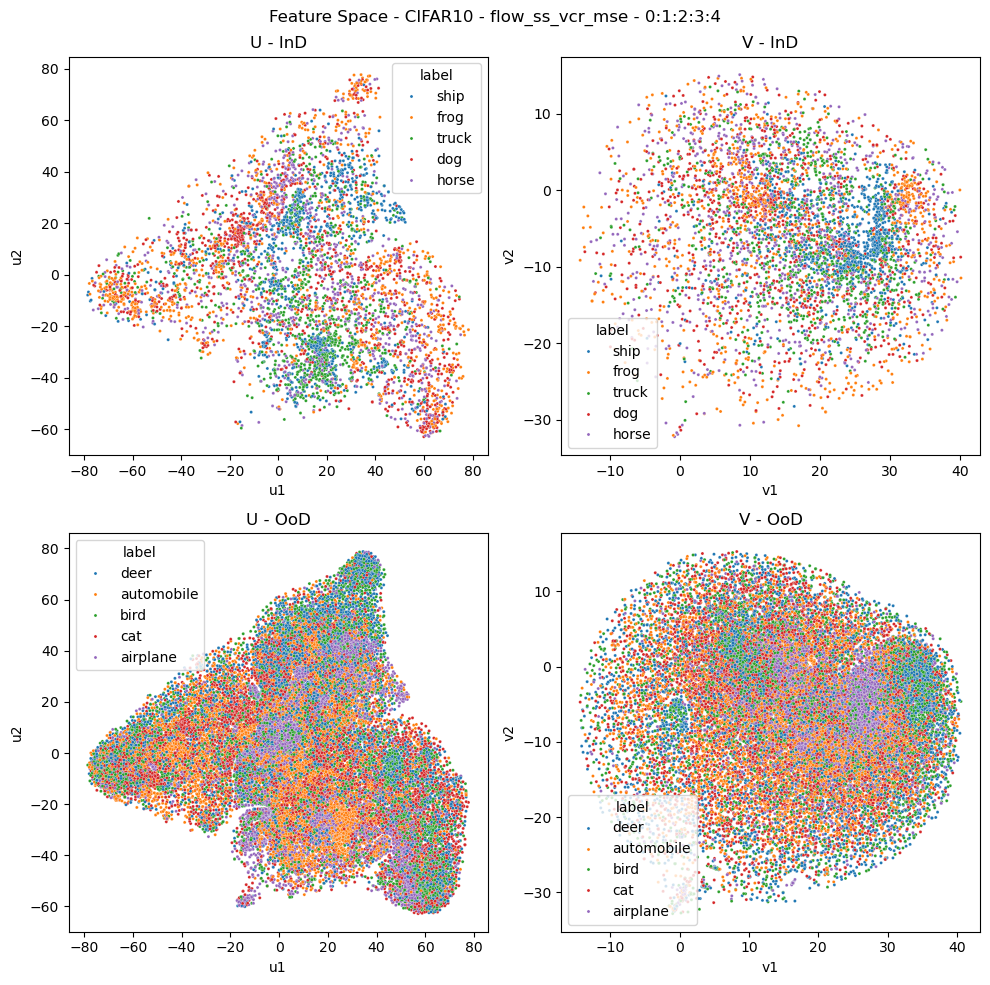

In [13]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

ind_labels = [config.labels[i] for i in ind_tgt]
emb_data = pd.DataFrame()
u1, u2 = ind_e_u2d.T
v1, v2 = ind_e_v2d.T
emb_data = pd.concat([emb_data, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ind_labels, source="ind"))])

if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]
    u1, u2 = ood_e_u2d.T
    v1, v2 = ood_e_v2d.T
    emb_data = pd.concat([emb_data, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ood_labels, source="ood"))])

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))

fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
ax1.set_title("U - InD")
ax2.set_title("V - InD")
ax3.set_title("U - OoD")
ax4.set_title("V - OoD")

sns.scatterplot(data=emb_data[(emb_data['source'] == "ind")], x="u1", y="u2", hue="label", s=5, ax=ax1)
sns.scatterplot(data=emb_data[(emb_data['source'] == "ind")], x="v1", y="v2", hue="label", s=5, ax=ax2)
sns.scatterplot(data=emb_data[(emb_data['source'] == "ood")], x="u1", y="u2", hue="label", s=5, ax=ax3)
sns.scatterplot(data=emb_data[(emb_data['source'] == "ood")], x="v1", y="v2", hue="label", s=5, ax=ax4)

plt.tight_layout()
plt.show()

  0%|                                                                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████████████████                                                                                          | 1/4 [00:01<00:04,  1.34s/it]

 50%|████████████████████████████████████████████████████████████                                                            | 2/4 [00:02<00:02,  1.36s/it]

 75%|██████████████████████████████████████████████████████████████████████████████████████████                              | 3/4 [00:04<00:01,  1.40s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.48s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.44s/it]

  0%|                                                                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████████████████                                                                                          | 1/4 [00:05<00:16,  5.61s/it]

 50%|████████████████████████████████████████████████████████████                                                            | 2/4 [00:11<00:11,  5.63s/it]

 75%|██████████████████████████████████████████████████████████████████████████████████████████                              | 3/4 [00:16<00:05,  5.67s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:22<00:00,  5.75s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:22<00:00,  5.71s/it]

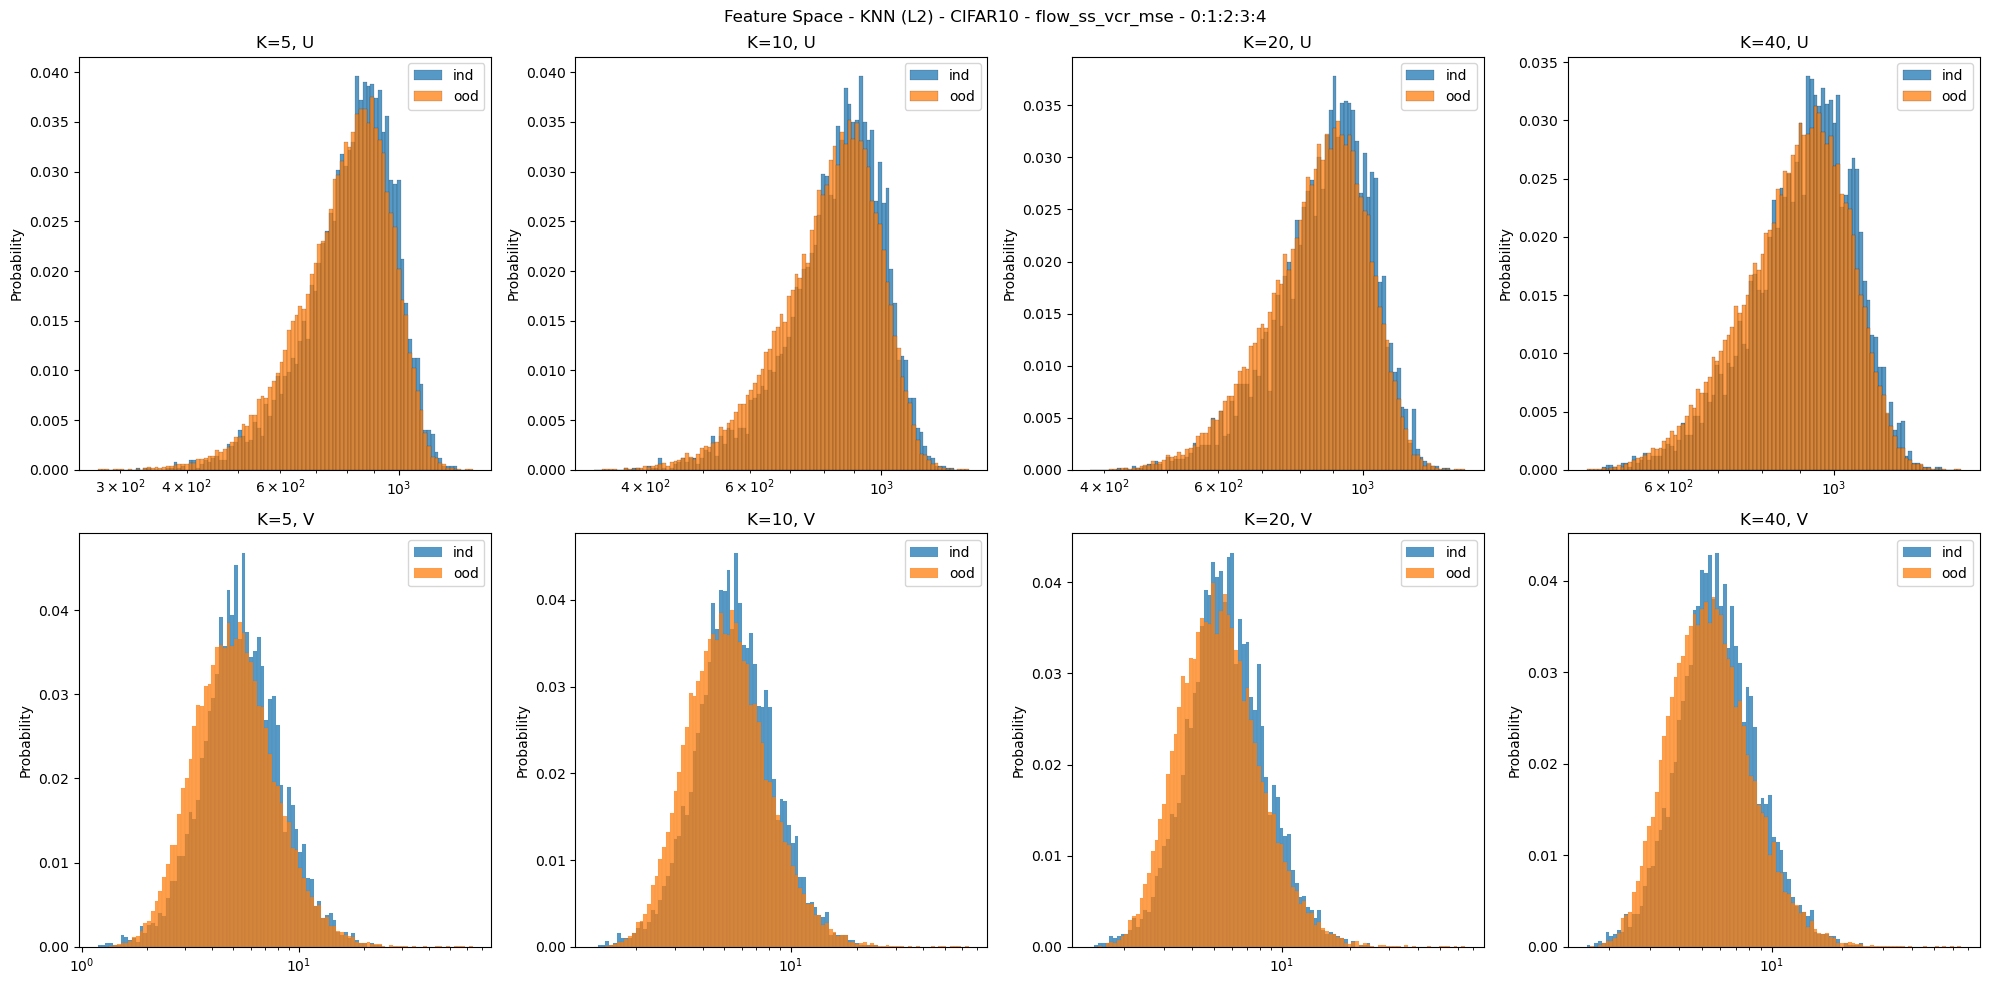

In [14]:
import faiss

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
fig.suptitle(f"Feature Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

index_e_u = faiss.IndexFlatL2(ind_e_u.shape[-1])
index_e_u.add(ind_e_u)
for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index_e_u.search(ind_e_u, k+1)[0][:, -k:].mean(-1) # avoid closest neighbor (itself)
    D = [Di]
    if ood_str:
        Do = index_e_u.search(ood_e_u, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min()), np.log10(D.max()), 100)
    ax = axs[0][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, U")
    ax.set_xscale('log')
    ax.legend()

index_e_v = faiss.IndexFlatL2(ind_e_v.shape[-1])
index_e_v.add(ind_e_v)
for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index_e_v.search(ind_e_v, k+1)[0][:, -k:].mean(-1) # avoid closest neighbor (itself)
    D = [Di]
    if ood_str:
        Do = index_e_v.search(ood_e_v, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min()), np.log10(D.max()), 100)
    ax = axs[1][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, V")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████████████████                                                                                          | 1/4 [00:01<00:03,  1.31s/it]

 50%|████████████████████████████████████████████████████████████                                                            | 2/4 [00:02<00:02,  1.32s/it]

 75%|██████████████████████████████████████████████████████████████████████████████████████████                              | 3/4 [00:04<00:01,  1.36s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.44s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.40s/it]

  0%|                                                                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████████████████                                                                                          | 1/4 [00:05<00:16,  5.55s/it]

 50%|████████████████████████████████████████████████████████████                                                            | 2/4 [00:11<00:11,  5.57s/it]

 75%|██████████████████████████████████████████████████████████████████████████████████████████                              | 3/4 [00:17<00:05,  5.72s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:22<00:00,  5.76s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:22<00:00,  5.72s/it]

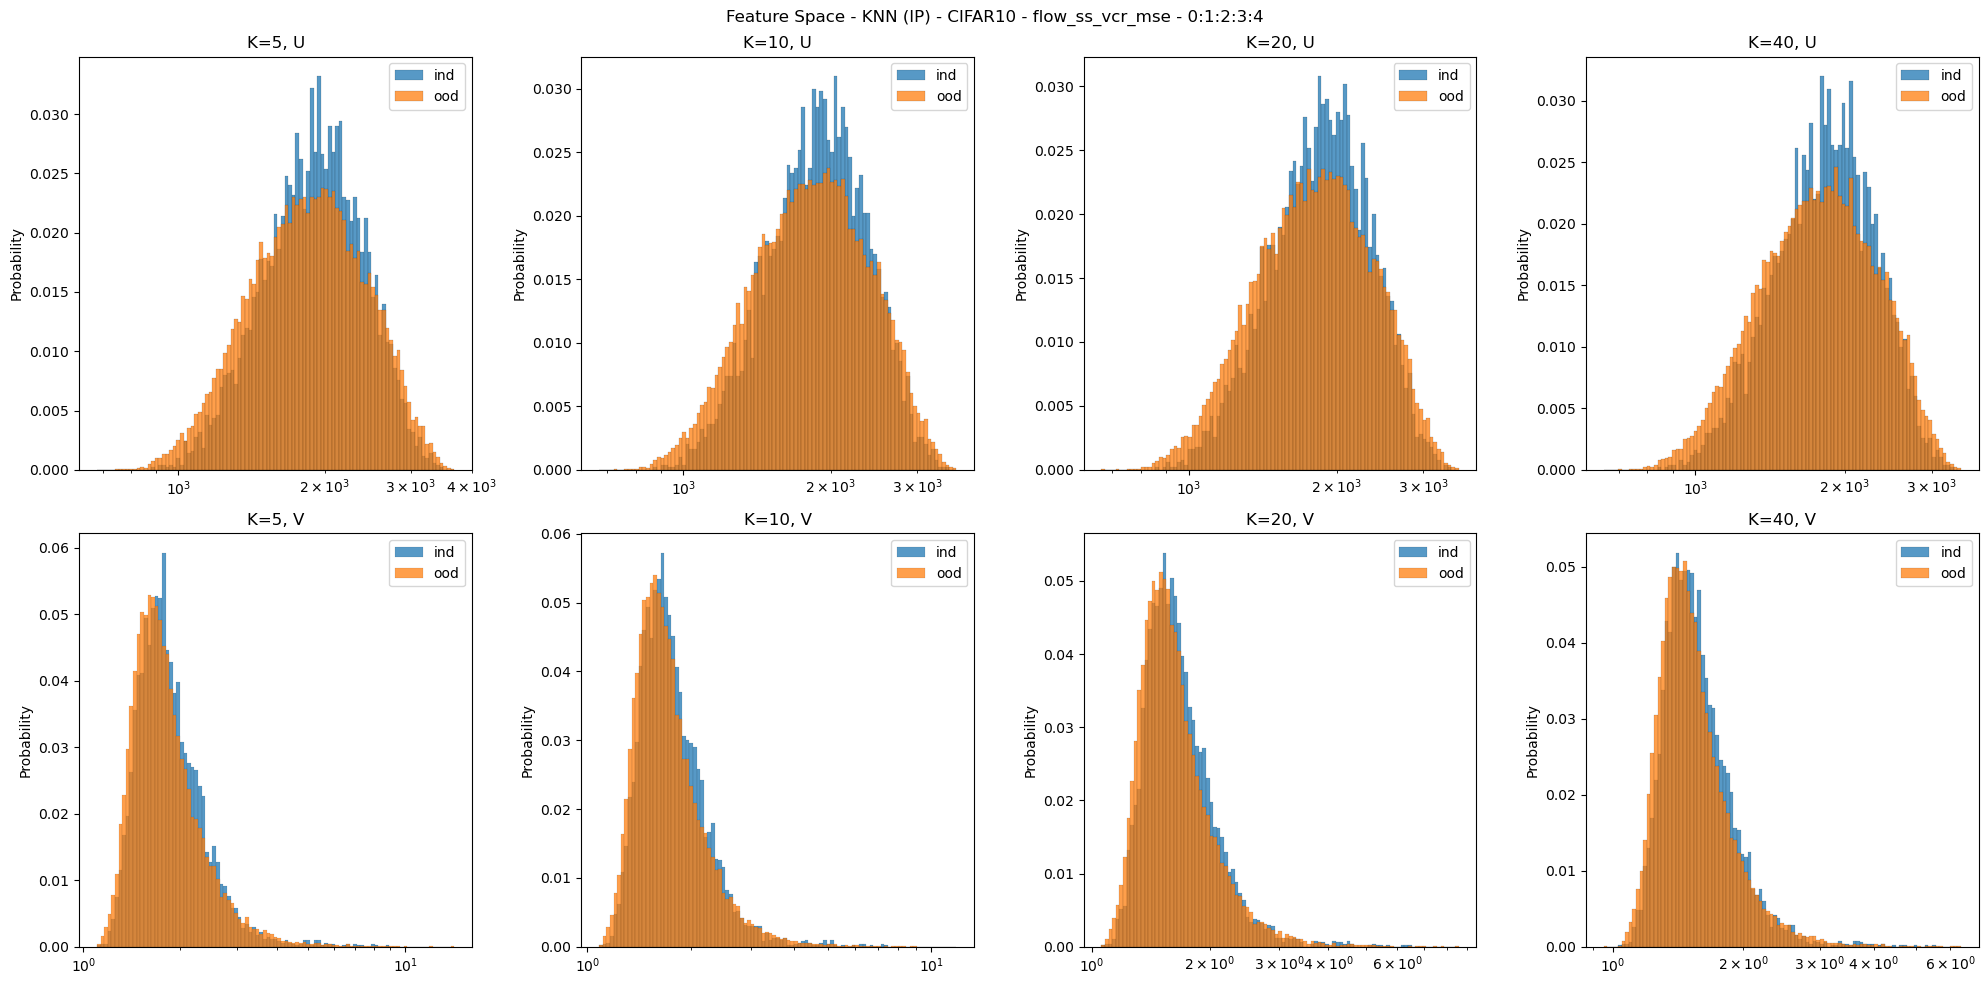

In [15]:
import faiss

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
fig.suptitle(f"Feature Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

index_e_u = faiss.IndexFlatIP(ind_e_u.shape[-1])
index_e_u.add(ind_e_u)
for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index_e_u.search(ind_e_u, k+1)[0][:, -k:].mean(-1) # avoid closest neighbor (itself)
    D = [Di]
    if ood_str:
        Do = index_e_u.search(ood_e_u, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min()), np.log10(D.max()), 100)
    ax = axs[0][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, U")
    ax.set_xscale('log')
    ax.legend()

index_e_v = faiss.IndexFlatIP(ind_e_v.shape[-1])
index_e_v.add(ind_e_v)
for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index_e_v.search(ind_e_v, k+1)[0][:, -k:].mean(-1) # avoid closest neighbor (itself)
    D = [Di]
    if ood_str:
        Do = index_e_v.search(ood_e_v, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min()), np.log10(D.max()), 100)
    ax = axs[1][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, V")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

In [16]:
from scipy.linalg import norm

trn_n_u = norm(trn_e_u, axis=-1)
trn_n_v = norm(trn_e_v, axis=-1)
val_n_u = norm(val_e_u, axis=-1)
val_n_v = norm(val_e_v, axis=-1)
ind_n_u = norm(ind_e_u, axis=-1)
ind_n_v = norm(ind_e_v, axis=-1)
if ood_str:
    ood_n_u = norm(ood_e_u, axis=-1)
    ood_n_v = norm(ood_e_v, axis=-1)
rnd_n_u = norm(rnd_e_u, axis=-1)
rnd_n_v = norm(rnd_e_v, axis=-1)

print(trn_n_u.mean(), trn_n_u.std(), trn_n_v.mean(), trn_n_v.std())
print(val_n_u.mean(), val_n_u.std(), val_n_v.mean(), val_n_v.std())
print(ind_n_u.mean(), ind_n_u.std(), ind_n_v.mean(), ind_n_v.std())
if ood_str:
    print(ood_n_u.mean(), ood_n_u.std(), ood_n_v.mean(), ood_n_v.std())
print(rnd_n_u.mean(), rnd_n_u.std(), rnd_n_v.mean(), rnd_n_v.std())

43.80354 5.5924077 2.3900492 0.4930947
43.68977 5.6359363 2.3761766 0.4961071
44.044376 5.57484 2.3879318 0.4925832
43.21832 6.486679 2.3105268 0.5200201
60.12006 2.602596 46.811386 0.7775296


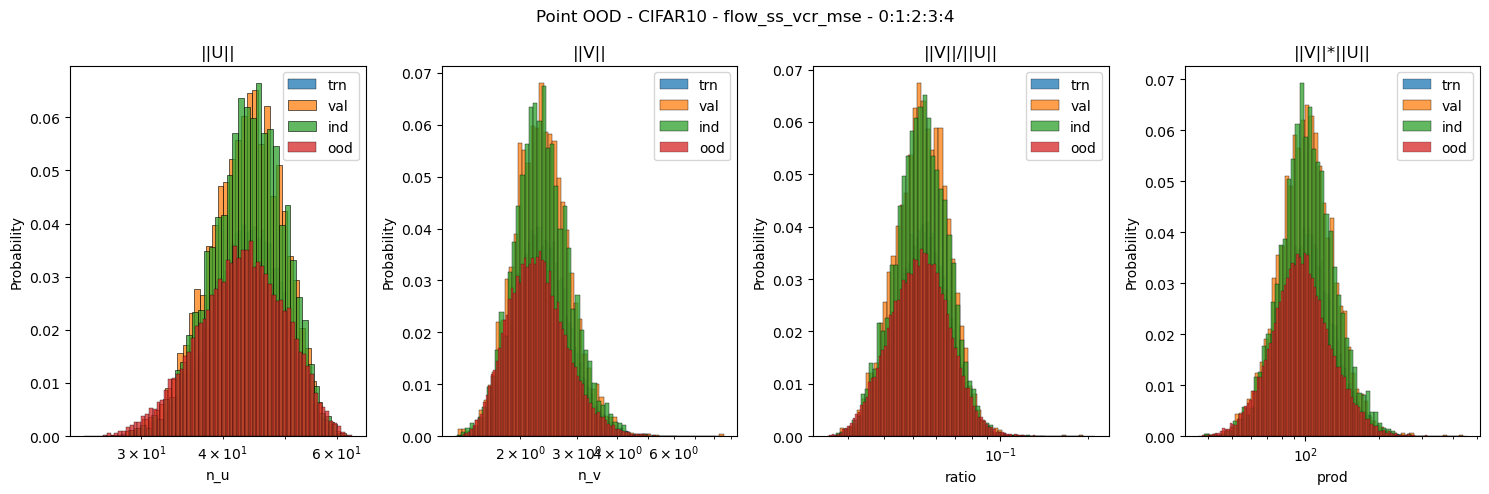

In [17]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

df_trn = pd.DataFrame(dict(n_u=trn_n_u, n_v=trn_n_v, ratio=trn_n_v/trn_n_u, prod=trn_n_v*trn_n_u, target=trn_tgt))
df_val = pd.DataFrame(dict(n_u=val_n_u, n_v=val_n_v, ratio=val_n_v/val_n_u, prod=val_n_v*val_n_u, target=val_tgt))
df_ind = pd.DataFrame(dict(n_u=ind_n_u, n_v=ind_n_v, ratio=ind_n_v/ind_n_u, prod=ind_n_v*ind_n_u, target=ind_tgt))
if ood_str:
    df_ood = pd.DataFrame(dict(n_u=ood_n_u, n_v=ood_n_v, ratio=ood_n_v/ood_n_u, prod=ood_n_v*ood_n_u, target=ood_tgt))
df_rnd = pd.DataFrame(dict(n_u=rnd_n_u, n_v=rnd_n_v, ratio=rnd_n_v/rnd_n_u, prod=rnd_n_v*rnd_n_u))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (15, 5))
fig.suptitle(f"Point OOD - {dataset_name} - {model_name} - {ood_str}")

def plot_row(prop, ax):
    sns.histplot(data=df_trn, x=prop, log_scale=True, fill=True, label='trn', stat='probability', ax=ax)
    sns.histplot(data=df_val, x=prop, log_scale=True, fill=True, label='val', stat='probability', ax=ax)
    sns.histplot(data=df_ind, x=prop, log_scale=True, fill=True, label='ind', stat='probability', ax=ax)
    if ood_str:
        sns.histplot(data=df_ood, x=prop, log_scale=True, fill=True, label='ood', stat='probability', ax=ax)
    # sns.histplot(data=df_rnd, x=prop, log_scale=True, fill=True, label='rnd', stat='density', ax=ax)
    ax.legend()

plot_row("n_u", ax1)
plot_row("n_v", ax2)
plot_row("ratio", ax3)
plot_row("prod", ax4)
ax1.title.set_text('||U||')
ax2.title.set_text('||V||')
ax3.title.set_text('||V||/||U||')
ax4.title.set_text('||V||*||U||')

plt.tight_layout()
plt.show()

In [18]:
if ood_str:
    df_tst = pd.concat([df_ind, df_ood], axis=0)
else:
    df_tst = df_ind

all_targets = list(df_tst['target'].unique())
K = len(all_targets)
N = 128
rw, rh = 2, 0.75
colors = sns.color_palette(n_colors=K)

pointwise_trn = {}
pointwise_val = {}
pointwise_tst = {}

groupwise_trn = {}
groupwise_val = {}
groupwise_tst = {}

for i in range(K):
    _trn = df_trn[df_trn['target'] == all_targets[i]]
    _val = df_val[df_val['target'] == all_targets[i]]
    _tst = df_tst[df_tst['target'] == all_targets[i]]
    pointwise_trn[i] = _trn.copy()
    pointwise_val[i] = _val.copy()
    pointwise_tst[i] = _tst.copy()
    groupwise_trn[i] = _trn.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_val[i] = _val.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_tst[i] = _tst.rolling(N).agg(['mean', 'std']).dropna().copy()


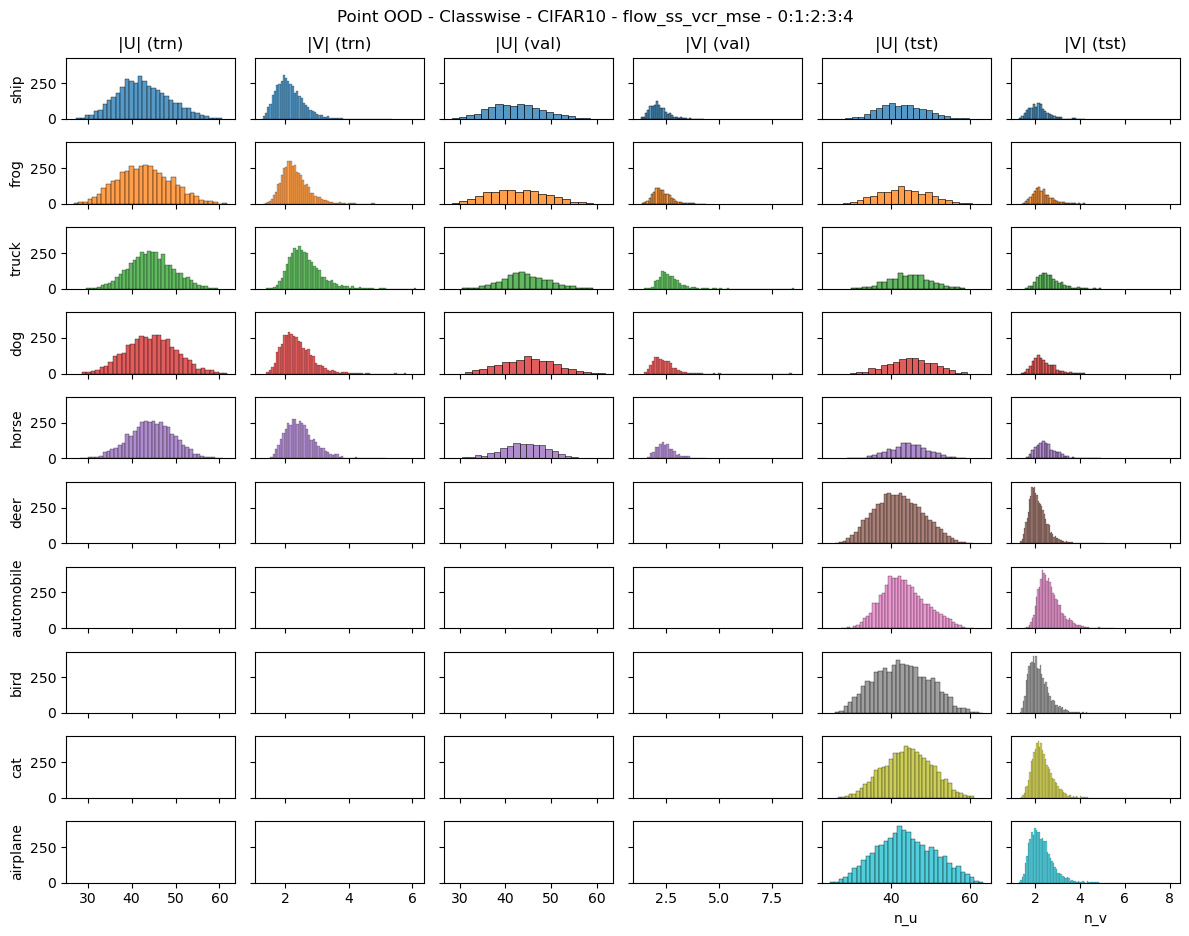

In [19]:
# pointwise
fig, axs = plt.subplots(K, 6, figsize=(6*rw, K*rh+2), sharex='col', sharey='all')
fig.suptitle(f"Point OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in range(K):
    _trn = pointwise_trn[i]
    _val = pointwise_val[i]
    _tst = pointwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn, x="n_u", fill=True, legend=False, color=_hue, ax=ax1)
        sns.histplot(data=_trn, x="n_v", fill=True, legend=False, color=_hue, ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val, x="n_u", fill=True, legend=False, color=_hue, ax=ax3)
        sns.histplot(data=_val, x="n_v", fill=True, legend=False, color=_hue, ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst, x="n_u", fill=True, legend=False, color=_hue, ax=ax5)
        sns.histplot(data=_tst, x="n_v", fill=True, legend=False, color=_hue, ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()

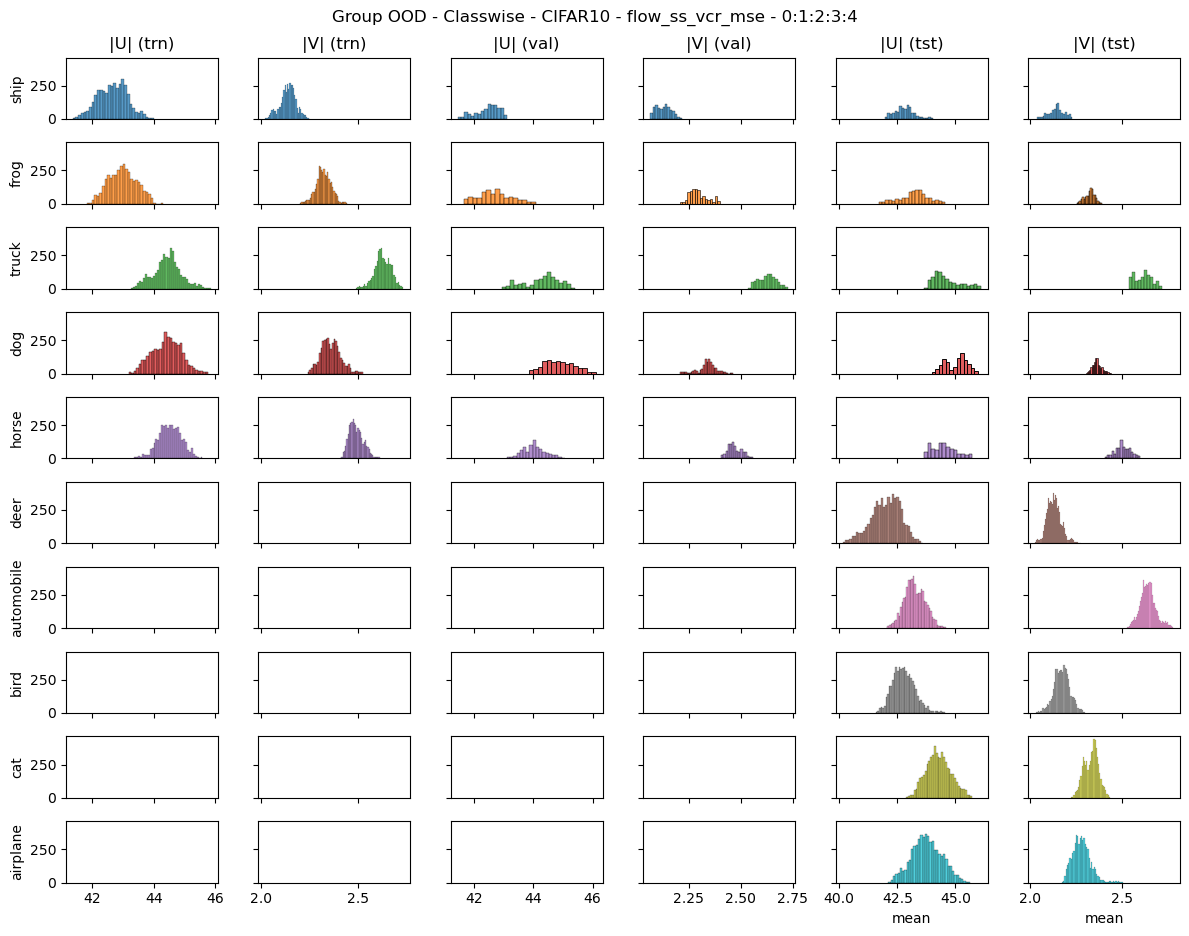

In [20]:
# groupwise
fig, axs = plt.subplots(K, 6, figsize = (6*rw, K*rh+2), sharex='col', sharey='all')
fig.suptitle(f"Group OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in all_targets:
    _trn = groupwise_trn[i]
    _val = groupwise_val[i]
    _tst = groupwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn.n_u, x="mean", fill=True, legend=False, color=_hue, ax=ax1)
        sns.histplot(data=_trn.n_v, x="mean", fill=True, legend=False, color=_hue, ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val.n_u, x="mean", fill=True, legend=False, color=_hue, ax=ax3)
        sns.histplot(data=_val.n_v, x="mean", fill=True, legend=False, color=_hue, ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst.n_u, x="mean", fill=True, legend=False, color=_hue, ax=ax5)
        sns.histplot(data=_tst.n_v, x="mean", fill=True, legend=False, color=_hue, ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()